<a href="https://colab.research.google.com/github/hiydavid/homl-learning/blob/main/projects/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10

---
# Load libraries & data

In [1]:
# load libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
import os

# check versions
print('matplotlib v.', mpl.__version__)
print('numpy      v.', np.__version__)
print('pandas     v.', pd.__version__)
print('sklearn    v.', sklearn.__version__)
print('tensorflow v.', tf.__version__)
print('keras      v.', keras.__version__)

matplotlib v. 3.2.2
numpy      v. 1.19.5
pandas     v. 1.1.5
sklearn    v. 0.22.2.post1
tensorflow v. 2.5.0
keras      v. 2.5.0


In [2]:
# load cifar10 data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)
(10000, 32, 32, 3) (10000, 1)


---
# Build model

1). Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.

In [3]:
# function to clear session and set seed
def clear_session(seed = 1234):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

clear_session()

In [17]:
# build model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(
        100, activation="elu", kernel_initializer="he_normal")
    )
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               307300    
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 100)              

2). Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.

In [5]:
# set optimizer
loss = keras.losses.sparse_categorical_crossentropy
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
metrics = keras.metrics.sparse_categorical_accuracy

# compile model
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [6]:
# impletment callbacks and early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my_cifar10_model.h5", 
    save_best_only=True
)

run_index = 1
run_logdir = os.path.join(
    os.curdir, 
    "my_cifar10_logs", 
    "run_{:03d}".format(run_index)
)

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [7]:
# fit model
model.fit(
    X_train, 
    y_train, 
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/50
1407/1407 [==============================] - 20s 10ms/step - loss: 4.2992 - sparse_categorical_accuracy: 0.1710 - val_loss: 2.1600 - val_sparse_categorical_accuracy: 0.2358
Epoch 2/50
1407/1407 [==============================] - 13s 9ms/step - loss: 2.1107 - sparse_categorical_accuracy: 0.2330 - val_loss: 2.1271 - val_sparse_categorical_accuracy: 0.2308
Epoch 3/50
1407/1407 [==============================] - 13s 9ms/step - loss: 1.9768 - sparse_categorical_accuracy: 0.2760 - val_loss: 2.0020 - val_sparse_categorical_accuracy: 0.2506
Epoch 4/50
1407/1407 [==============================] - 13s 9ms/step - loss: 1.8929 - sparse_categorical_accuracy: 0.3094 - val_loss: 1.8800 - val_sparse_categorical_accuracy: 0.3094
Epoch 5/50
1407/1407 [==============================] - 13s 9ms/step - loss: 1.8309 - sparse_categorical_accuracy: 0.3375 - val_loss: 1.8148 - val_sparse_categorical_accuracy: 0.3400
Epoch 6/50
1407/1407 [==============================] - 13s 9ms/step - loss: 1.7712 

In [8]:
# load best and evaluate
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.4914 - sparse_categorical_accuracy: 0.4736


[1.491390347480774, 0.47360000014305115]

3). Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

In [19]:
# clear session
clear_session()

In [20]:
# build model with batch norm
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [11]:
# set optimizer with different learning rate
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [12]:
# implement callback and early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my_cifar10_bn_model.h5", 
    save_best_only=True
)

run_index = 1
run_logdir = os.path.join(
    os.curdir, 
    "my_cifar10_logs", 
    "run_bn_{:03d}".format(run_index)
)

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# fit model
model.fit(
    X_train, 
    y_train, 
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# evaluate
model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/50
1407/1407 [==============================] - 46s 26ms/step - loss: 1.8285 - sparse_categorical_accuracy: 0.3451 - val_loss: 1.6275 - val_sparse_categorical_accuracy: 0.4168
Epoch 2/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6601 - sparse_categorical_accuracy: 0.4117 - val_loss: 1.5554 - val_sparse_categorical_accuracy: 0.4428
Epoch 3/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5992 - sparse_categorical_accuracy: 0.4304 - val_loss: 1.5109 - val_sparse_categorical_accuracy: 0.4586
Epoch 4/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5455 - sparse_categorical_accuracy: 0.4483 - val_loss: 1.5264 - val_sparse_categorical_accuracy: 0.4564
Epoch 5/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5007 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.4533 - val_sparse_categorical_accuracy: 0.4788
Epoch 6/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.

[1.3213551044464111, 0.5522000193595886]

4). Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [21]:
# clear session
clear_session()

In [22]:
# build and compile model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(
        100, kernel_initializer="lecun_normal", activation="selu")
    )
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [23]:
# set optimizer
optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [24]:
# implement early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model.h5", 
    save_best_only=True
)

run_index = 1 # increment every time you train the model
run_logdir = os.path.join(
    os.curdir, 
    "my_cifar10_logs", 
    "run_selu_{:03d}".format(run_index)
)

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [25]:
# normalize
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [27]:
# fit and evaluate model
model.fit(
    X_train_scaled, y_train, epochs=50,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=callbacks
)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/50
1407/1407 [==============================] - 15s 11ms/step - loss: 1.8232 - sparse_categorical_accuracy: 0.3486 - val_loss: 1.7817 - val_sparse_categorical_accuracy: 0.3528
Epoch 2/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6566 - sparse_categorical_accuracy: 0.4127 - val_loss: 1.6896 - val_sparse_categorical_accuracy: 0.4054
Epoch 3/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5774 - sparse_categorical_accuracy: 0.4411 - val_loss: 1.6401 - val_sparse_categorical_accuracy: 0.4276
Epoch 4/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5149 - sparse_categorical_accuracy: 0.4694 - val_loss: 1.5484 - val_sparse_categorical_accuracy: 0.4568
Epoch 5/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4653 - sparse_categorical_accuracy: 0.4868 - val_loss: 1.6324 - val_sparse_categorical_accuracy: 0.4322
Epoch 6/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.

[1.4697763919830322, 0.4875999987125397]

5). Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

In [28]:
# clear session
clear_session()

In [30]:
# build model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(
        100, kernel_initializer="lecun_normal", activation="selu")
    )

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               307300    
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [32]:
# set optimizer
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [33]:
# early stopping and callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model.h5", 
    save_best_only=True
)

run_index = 1 # increment every time you train the model
run_logdir = os.path.join(
    os.curdir, 
    "my_cifar10_logs", 
    "run_alpha_dropout_{:03d}".format(run_index)
)

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [34]:
# normalize data
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [35]:
# fit model and evaluate
model.fit(
    X_train_scaled, 
    y_train, 
    epochs=50,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=callbacks
)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/50
1407/1407 [==============================] - 70s 48ms/step - loss: 1.9006 - sparse_categorical_accuracy: 0.3252 - val_loss: 1.8142 - val_sparse_categorical_accuracy: 0.3654
Epoch 2/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6623 - sparse_categorical_accuracy: 0.4130 - val_loss: 1.6215 - val_sparse_categorical_accuracy: 0.4346
Epoch 3/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5697 - sparse_categorical_accuracy: 0.4484 - val_loss: 1.6208 - val_sparse_categorical_accuracy: 0.4350
Epoch 4/50
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5005 - sparse_categorical_accuracy: 0.4730 - val_loss: 1.5973 - val_sparse_categorical_accuracy: 0.4526
Epoch 5/50
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4525 - sparse_categorical_accuracy: 0.4906 - val_loss: 1.5886 - val_sparse_categorical_accuracy: 0.4596
Epoch 6/50
1407/1407 [==============================] - 13s 9ms/step - loss: 1.3

[1.5165354013442993, 0.49459999799728394]

In [36]:
# create mc alpha dropout
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [37]:
# add mc alpha dropout to model 
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

mc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               307300    
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [38]:
# utiliy functions
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [39]:
# clear session and make prediction with new model
clear_session()

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4968

6). Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [40]:
# clear session
clear_session()

In [41]:
# build model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(
        100, kernel_initializer="lecun_normal", activation="selu")
)

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [42]:
# set optimizer
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [52]:
import math

# learning rate
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

352/352 [==============================] - 3s 6ms/step - loss: nan - sparse_categorical_accuracy: 0.1487


(9.999999747378752e-06,
 9.615227699279785,
 2.5806734561920166,
 3.960209403719221)

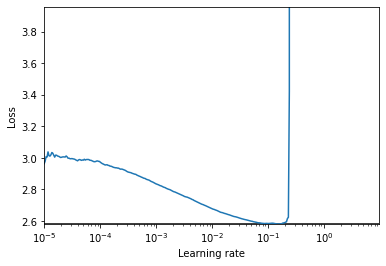

In [47]:
# find learning rate
batch_size = 128
rates, losses = find_learning_rate(
    model, 
    X_train_scaled, 
    y_train, 
    epochs=1, 
    batch_size=batch_size
)

plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [49]:
# clear session and rebuild model
clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(
        100, kernel_initializer="lecun_normal", activation="selu")
    )

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [50]:
# set optimizer
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [53]:
# fit
n_epochs = 15
onecycle = OneCycleScheduler(
    math.ceil(len(X_train_scaled) / batch_size) * n_epochs, 
    max_rate=0.05)

history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=n_epochs, 
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[onecycle]
)

Epoch 1/15
352/352 [==============================] - 3s 6ms/step - loss: 2.0374 - sparse_categorical_accuracy: 0.2881 - val_loss: 1.7638 - val_sparse_categorical_accuracy: 0.3766
Epoch 2/15
352/352 [==============================] - 2s 5ms/step - loss: 1.7452 - sparse_categorical_accuracy: 0.3834 - val_loss: 1.6550 - val_sparse_categorical_accuracy: 0.4110
Epoch 3/15
352/352 [==============================] - 2s 5ms/step - loss: 1.6188 - sparse_categorical_accuracy: 0.4239 - val_loss: 1.6604 - val_sparse_categorical_accuracy: 0.4248
Epoch 4/15
352/352 [==============================] - 2s 5ms/step - loss: 1.5406 - sparse_categorical_accuracy: 0.4505 - val_loss: 1.6910 - val_sparse_categorical_accuracy: 0.4210
Epoch 5/15
352/352 [==============================] - 2s 5ms/step - loss: 1.4859 - sparse_categorical_accuracy: 0.4703 - val_loss: 1.6086 - val_sparse_categorical_accuracy: 0.4400
Epoch 6/15
352/352 [==============================] - 2s 5ms/step - loss: 1.4454 - sparse_categorica